<a href="https://colab.research.google.com/github/ShoSato-047/STAT380/blob/main/STAT380_4_4_(2025)_multiple_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In many cases, we want to model the relationship between a binary response $Y$ and *multiple* covariates $X_1$, $X_2$,..., $X_p$.  The motivation is very similar to why we want to use multiple covariates in ordinary linear regression:

* The log-odds of $Y=1$ might be nonlinearly related to $X_1$, such that higher-order (e.g. polynomial, $X_1^2$, $X_1^3$, etc.) terms may be required.
* The relationship of $Y$ with $X_1$ might be confounded by $X_2$, so that we want to interpret odds ratios of $Y$ with $X_1$ ***conditioned on*** $X_2$.
* The relationship of $Y$ with $X_1$ might differ by $X_2$, so that we want to model an interaction between $X_1$ and $X_2$.

# Comparing models

For *nested* models of the form:


$$\mbox{Simple model:  } logit(p) = \beta_0 + \beta_1 X_1 + ... + \beta_p X_p$$

$$\mbox{Larger model:  } logit(p) = \mbox{all simple model terms} + \beta_{p+1}X_{p+1} + ... + \beta_{p+k}X_{p+k}$$


we can use the drop-in-deviance (aka likelihood ratio test) to test:

$$H_0: \mbox{the simple model is sufficient;  }\beta_{p+1}=...=\beta_{p+k} = 0$$
$$H_0: \mbox{the larger model is necessary;  at least one of }\beta_{p+1},...,\beta_{p+k} \ne 0$$

We can also use AIC and BIC to try to determine an optimal model; remember smaller is better.


If trying to compare models that are *not* nested, we cannot use the likelihood ratio test, but we can still compare AIC/BIC to try to settle on an appropriate model.

# Case study: teen weight loss

The data for this problem come from the U.S. Youth Risk Behavior Surveillance System (YRBSS).  The [YRBSS](https://www.cdc.gov/healthyyouth/data/yrbs/index.htm) is an annual national school-based survey conducted by the Centers for Disease Control and Prevention (CDC) and state, territorial, and local education and health agencies and tribal governments.  (Data sourced from [Roback and Legler](https://bookdown.org/roback/bookdown-BeyondMLR/ch-logreg.html#case-study-trying-to-lose-weight).)

The prevalence of obesity among U.S. youth suggests that wanting to lose weight is sensible and desirable for some young people such as those with a high body mass index (BMI). On the flip side, there are young people who do not need to lose weight but make ill-advised attempts to do so nonetheless.

Question 66 on the YRBSS asks: *Which of the following are you trying to do about your weight?*  The possible responses were:

A. Lose weight  
B. Gain weight   
C. Stay the same weight   
D. I am not trying to do anything about my weight   

For this problem our response variable $Y$ is 1 if the teen answered "lose weight" and 0 otherwise.


In [2]:
library(tidyverse)
yrbss <- read.csv('https://www.dropbox.com/s/x09q8ec1gasnkq1/risk2009.txt?dl=1') %>%
   mutate(bmidecile = round(bmipct/10))
head(yrbss)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


,lose.wt,lose.wt.01,sex,sport,sport_fac,sport_num,media,bmipct,bmidecile
,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<dbl>
1,Lose weight,1,Male,No sports,0 teams,0,3,98,10
2,No weight loss,0,Female,No sports,0 teams,0,1,41,4
3,No weight loss,0,Male,Sports,1 team,1,3,6,1
4,No weight loss,0,Male,No sports,0 teams,0,3,41,4
5,Lose weight,1,Male,No sports,0 teams,0,3,99,10
6,No weight loss,0,Male,No sports,0 teams,0,2,97,10


In [3]:
#Code for widening plots:
library(repr)
options(repr.plot.width=10, repr.plot.height=5)

In [4]:
dim(yrbss)

[1] 445   9


We have several covariates which may relate to the odds of trying to lose weight, including:

* `bmipct`: the percentile for a given BMI for members of the same sex. This facilitates comparisons when modeling with males and females.  `bmidecile` groups each percentile into one of the deciles (10-percentile groupings).
*  `sex`
*  `sport_num`, the number of sports teams each teen participates in (0, 1, 2, or 3+).  Corresponding variable `sport` is a binary variable indicating whether or not the teen plays on any sports teams
* `media`: a variable indicating how many hours per day teens watch TV.  This is based on Question 81 from the YRBSS: "On an average school day, how many hours do you watch TV?" Possible values: 0 (I do not watch TV on an average school day), 0.5 (Less than 1 hour per day), 1 (1 hr per day), 2 (2 hrs per day), 3 (3 hrs per day), 4 (4 hrs per day), and 5 (5 or more hrs per day).


# Research question 1:  Is BMI associated with an interest in losing weight?  If so, how?



## Exploratory analysis

The variable `bmipct` is our primary $X$ variable for this question.  We could try to visualize the relationship between the BMI percentiles and the response variable `lose.wt.01` in two ways:

* A **stacked bar graph** indicating the proportion trying to lose weight in each BMI percentile - this visualizes how $\hat p$ varies with $X$;
* Calculating the empirical (i.e., observed) $logit(\hat p)$ (log-odds) of trying to lose weight, and creating a **scatterplot** of these logits versus the percentiles.

Let's try a stacked bar graph first:

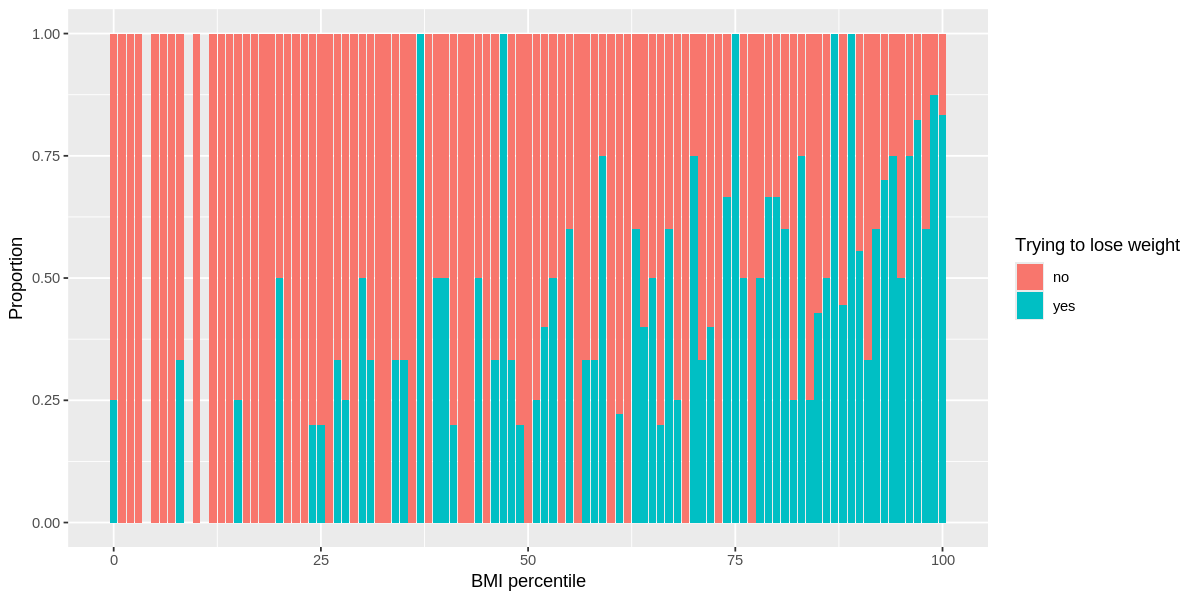

In [5]:
ggplot(data = yrbss) +
  geom_bar(aes(x = bmipct, fill = factor(lose.wt.01)), position = 'fill') +
    ylab('Proportion') + xlab('BMI percentile') +
      scale_fill_discrete(name = 'Trying to lose weight', labels = c('no','yes'))

The relationship is quite noisy!  This is because we have so few observations in each unique BMI percentile.  We can see this if we try to compute the empirical logits for each BMI percentile:

In [6]:
yrbss %>%
  group_by(bmipct) %>%
    summarize(ntrying = sum(lose.wt.01 ==1), total = n()) %>%
      mutate(p = ntrying/total) %>%
        mutate(logit.p = log(p/(1-p))) %>%
          head(10)

bmipct,ntrying,total,p,logit.p
<int>,<int>,<int>,<dbl>,<dbl>
0,1,4,0.2500000,-1.0986123
1,0,1,0.0000000,-Inf
2,0,1,0.0000000,-Inf
3,0,1,0.0000000,-Inf
5,0,2,0.0000000,-Inf
6,0,2,0.0000000,-Inf
7,0,2,0.0000000,-Inf
8,1,3,0.3333333,-0.6931472
10,0,4,0.0000000,-Inf


Note that due to to the small counts in each unique BMI percentile, this results in lots of 0 and 1 proportions resulting in infinite (or negative infinite) logits.  A scatterplot will have a lot of missing data!




An alternative exploratory approach would be to visualize the relationship using the deciles, instead of percentiles, to increase the amount of data in each bin.

Doing this with the stacked bar graph:

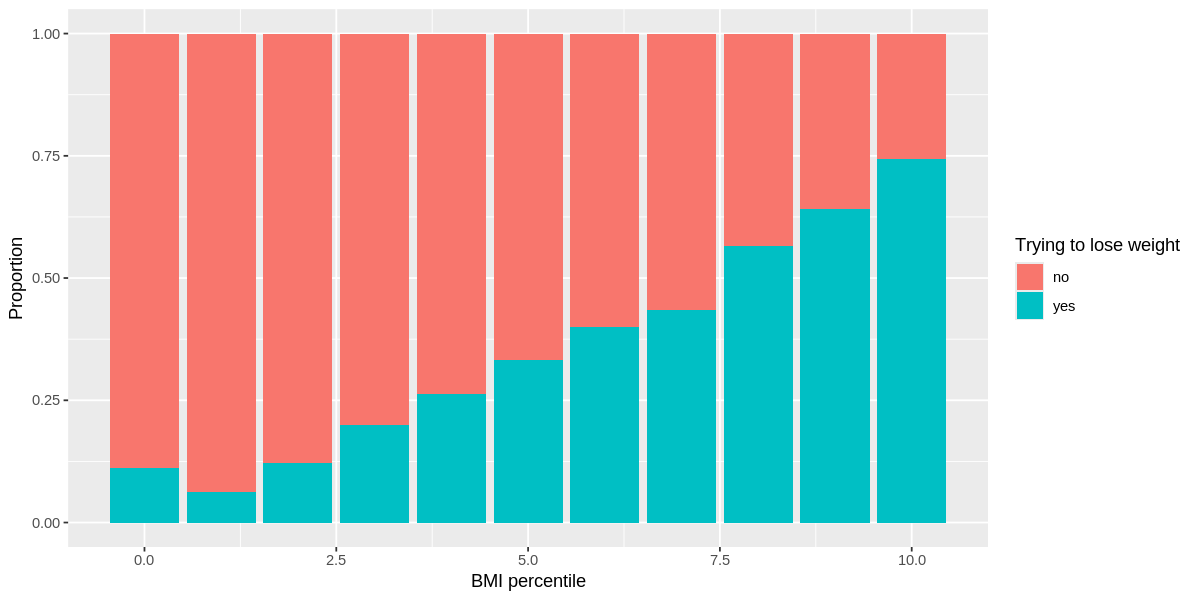

In [7]:
ggplot(data = yrbss) +
  geom_bar(aes(x = bmidecile, fill = factor(lose.wt.01)), position = 'fill') +
    ylab('Proportion') + xlab('BMI percentile') +
      scale_fill_discrete(name = 'Trying to lose weight', labels = c('no','yes'))

This shows a much less noisy relationship!  Let's find the empirical logits and plot those versus the deciles:

In [8]:
(empirical.logits <- yrbss %>%
  group_by(bmidecile) %>%
    summarize(ntrying = sum(lose.wt.01 ==1), total = n()) %>%
      mutate(p = ntrying/total) %>%
        mutate(logit.p = log(p/(1-p)))
)

bmidecile,ntrying,total,p,logit.p
<dbl>,<int>,<int>,<dbl>,<dbl>
0,1,9,0.1111111,-2.0794415
1,1,16,0.0625000,-2.7080502
2,4,33,0.1212121,-1.9810015
3,6,30,0.2000000,-1.3862944
4,11,42,0.2619048,-1.0360919
5,10,30,0.3333333,-0.6931472
6,18,45,0.4000000,-0.4054651
7,20,46,0.4347826,-0.2623643
8,30,53,0.5660377,0.2657032


This yields much more stable logits, which we can then plot vs the BMI deciles:

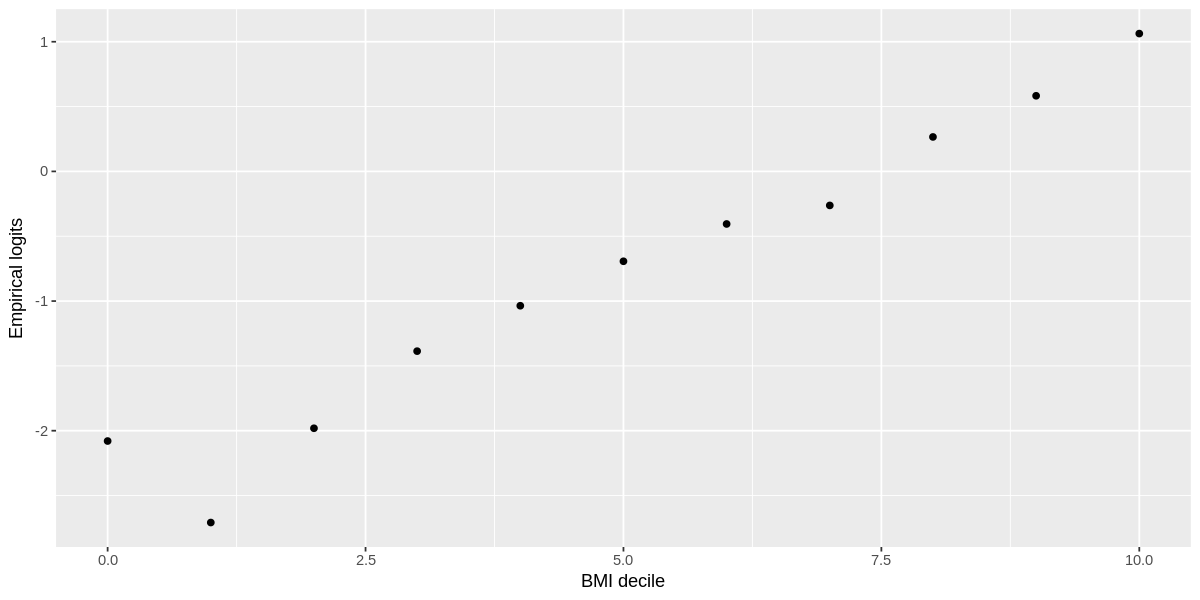

In [9]:
ggplot(data = empirical.logits) +
  geom_point(aes(x = bmidecile, y = logit.p)) +
    xlab('BMI decile') + ylab('Empirical logits')

## Model fitting

Increasing BMI appears to be positively associated with the log-odds of trying to lose weight, and the relationship appears quite linear.  Let's go ahead and fit a *simple* logistic model using the BMI decile as our single $X$ term, specifically:

$$logit(p_i) = \beta_0 + \beta_1 BMIdecile_i$$

In [10]:
bmid.fit <- glm(lose.wt.01 ~ bmidecile, data = yrbss, family=binomial)
summary(bmid.fit)


Call:
glm(formula = lose.wt.01 ~ bmidecile, family = binomial, data = yrbss)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.5522     0.3095  -8.245   <2e-16 ***
bmidecile     0.3529     0.0422   8.362   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 611.93  on 444  degrees of freedom
Residual deviance: 523.72  on 443  degrees of freedom
AIC: 527.72

Number of Fisher Scoring iterations: 4


In [11]:
exp(confint(bmid.fit))

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),0.04146918,0.1398747
bmidecile,1.31339183,1.5501145


* Interpret $\hat\beta_0$ (or a function of it).
  * **The log-odds of trying to loose weight are -2.55 for people in the first deicile category(bmidecile = 0).**
  * **The odds of trying to loose weight  for people in the first decile category are 0.078 (NOTE: In the first decile category, 7.8 people trying to loose weight for every 100 people who are not trying to loose weight).**

In [42]:
exp(-2.55)

[1] 0.07808167


  
* Interpret $\hat\beta_1$ (or a function of it).
  * **The log odds of trying to loose weight increase by 0.53 for every increase in BMI decile.**
  * **The odds of trying to lose weight are 1.42 times higher for each 1-decile increase in BMI.**

In [43]:
# odds ratio for each 1-decile increase:
exp(0.353)

[1] 1.423331


* Is there evidence of a relationship between BMI and intention to lose weight?
  * **Yes, the p-value for the slope is < 0.0001. And the CI for the exponentiated slope does not include 1.**

Adding the fitted values to the empirical logit plot:

In [44]:
# prediction function
empirical.logits$fitted.logits <- predict(bmid.fit, newdata = empirical.logits)

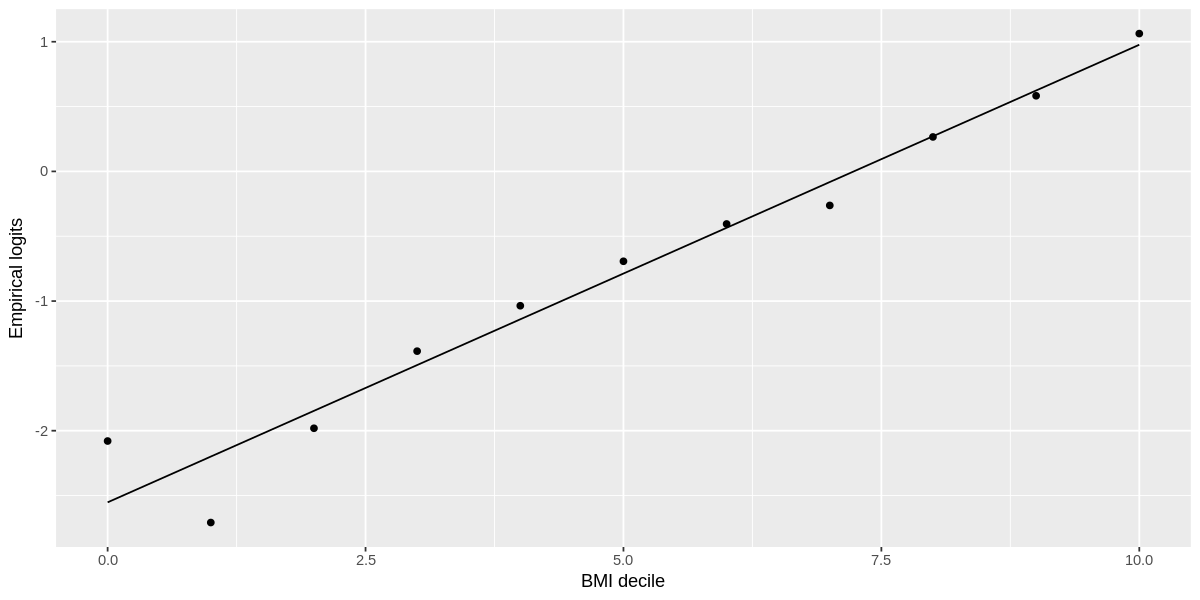

In [45]:
ggplot(data = empirical.logits) +
  geom_point(aes(x = bmidecile, y = logit.p)) +
      geom_line(aes(x = bmidecile, y = fitted.logits)) +
    xlab('BMI decile') + ylab('Empirical logits')

The fitted values very well-fit the empirical, observed relationship between the log-odds of wanting to lose weight and the BMI deciles.

# Research question 2: Does the relationship between BMI and weight-loss interest depend on sex?

## Exploratory analysis


We can explore this *multivariate* relationship in two ways:

* With **faceted stacked bar graphs** of $\hat p$, the observed *proportions* of those trying to lose weight, by BMI decile *faceted by sex*;
* With a **color-coded scatterplot** of  $logit(\hat p)$, the observed *log-odds* of those trying to lose weight, versus BMI decile *color-coded by sex*.

Creating the faceted stacked bar graph:

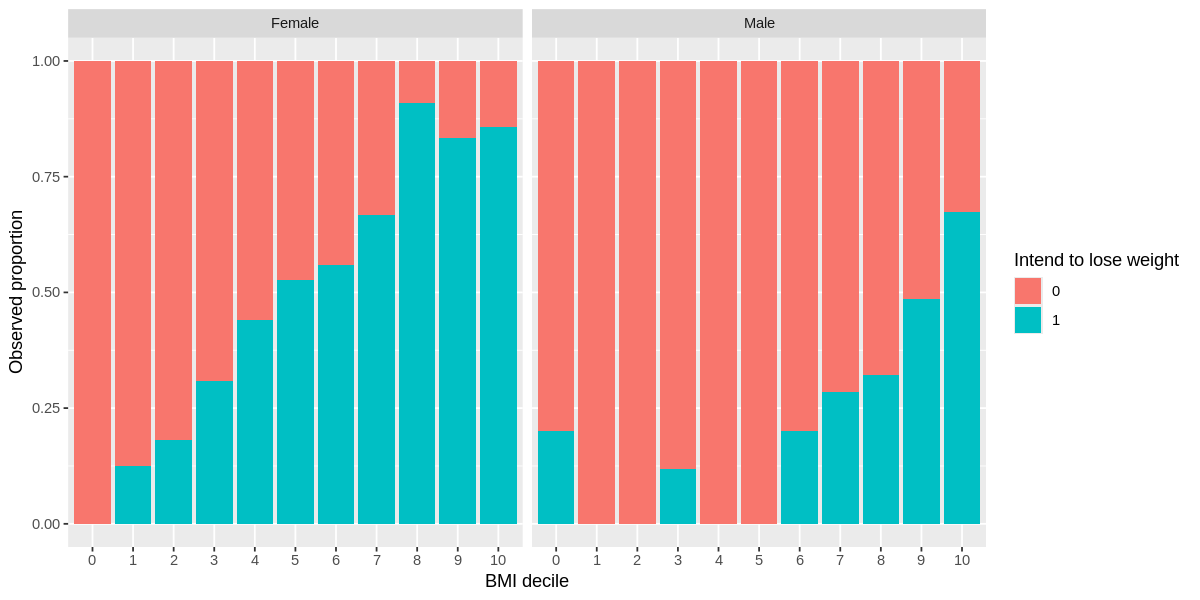

In [14]:
ggplot(data = yrbss) +
  geom_bar(aes(x = factor(bmidecile), fill = factor(lose.wt.01)), position = 'fill') +
    facet_wrap(~sex) +
      xlab('BMI decile') + ylab('Observed proportion') +
        scale_fill_discrete(name = 'Intend to lose weight')


To find the empirical logits we need to find $logit(\hat p)$ for each sex/BMI decile combination:

In [46]:
(empirical.logits.sex <- yrbss %>%
  group_by(sex,bmidecile) %>%
    summarize(ntrying = sum(lose.wt.01 ==1), total = n()) %>%
      mutate(p = ntrying/total) %>%
        mutate(logit.p = log(p/(1-p)))
)

`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


sex,bmidecile,ntrying,total,p,logit.p
<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>
Female,0,0,4,0.0000000,-Inf
Female,1,1,8,0.1250000,-1.94591015
Female,2,4,22,0.1818182,-1.50407740
Female,3,4,13,0.3076923,-0.81093022
Female,4,11,25,0.4400000,-0.24116206
Female,5,10,19,0.5263158,0.10536052
Female,6,14,25,0.5600000,0.24116206
Female,7,12,18,0.6666667,0.69314718
Female,8,20,22,0.9090909,2.30258509


In [49]:
# verifiying the last fitted value, for fun:
bmi.sex.nointeraction$coefficients

(Intercept)   bmidecile     sexMale 
 -2.3676608   0.4678507  -1.8713769

In [50]:
# b0 + b1*10 + b2*1
-2.36766079976241 + 0.467850733852413*10 + -1.87137688548091*1

[1] 0.4394697

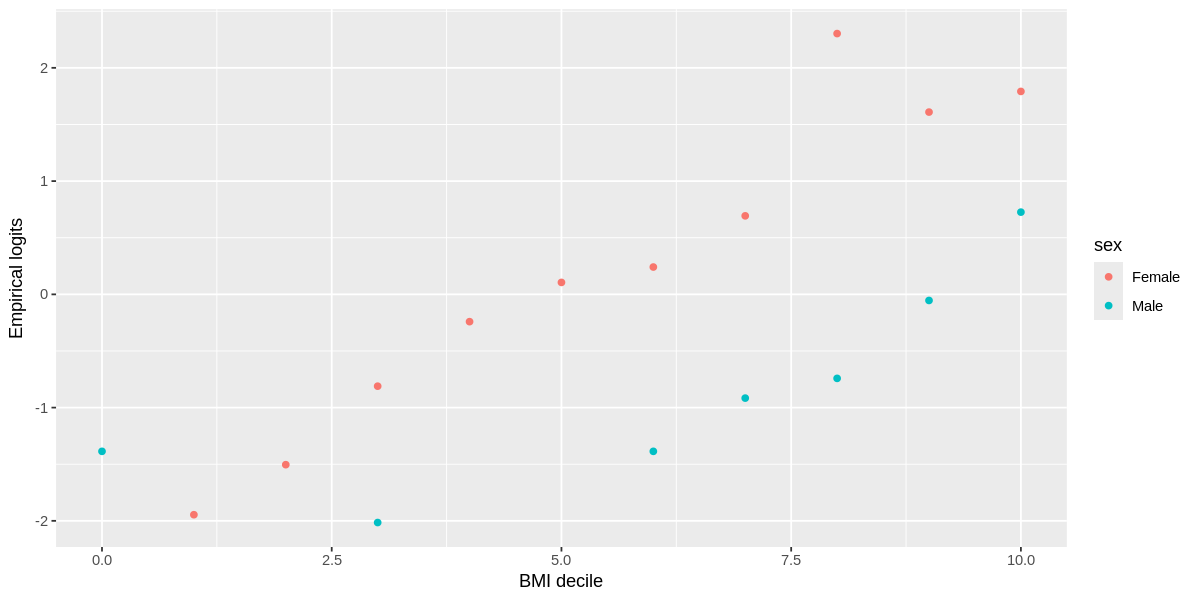

In [16]:
ggplot(data = empirical.logits.sex %>% filter(p > 0 & p < 1)) +
  geom_point(aes(x = bmidecile, y = logit.p,col=sex)) +
    xlab('BMI decile') + ylab('Empirical logits')

Of note:

* For both males and females, BMI is linearly related with log-odds of intention to lose weight *for the most part*.  The BMI decile of 0 for males yields a higher logit producing more of a "hockey stick" pattern; this could be noise though as there are only 5 males in this BMI decile.
* The relationship appears roughly the same for both males and females
* Conditioning on a given BMI decile, the log-odds of wanting to lose weight appear higher for females than males

## Model fitting: no interaction

Our first *multiple logistic regression* model of the log-odds of intending to lose weight as a function of *both* BMI and sex is as follows:

$$logit(p) = \beta_0 + \beta_1 X_1 + \beta_2 X_2$$

* $X_1$ = BMI decile, modeled as a *continuous* variable;
*  $X_2 = 1$ for males $0$ for females (to be consistent with R's alphabetical dummy variable creation).

This is a *no interaction* model, i.e., "different intercepts/common slopes."  Conceptually, this model assumes:

1. The positive relationship of wanting to lose weight with BMI is the same for males and females;
2. The gap between males and females in their intention to lose weight is the same at all BMI deciles.



Fitting the model:


In [17]:
bmi.sex.nointeraction <- glm(lose.wt.01~bmidecile + sex, data = yrbss, family=binomial)
summary(bmi.sex.nointeraction)


Call:
glm(formula = lose.wt.01 ~ bmidecile + sex, family = binomial, 
    data = yrbss)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.3677     0.3342  -7.085 1.39e-12 ***
bmidecile     0.4678     0.0517   9.050  < 2e-16 ***
sexMale      -1.8714     0.2599  -7.200 6.02e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 611.93  on 444  degrees of freedom
Residual deviance: 461.21  on 442  degrees of freedom
AIC: 467.21

Number of Fisher Scoring iterations: 5


Adding the fitted values to the empirical logit data frame, and plotting:

In [18]:
empirical.logits.sex$fitted.values <- predict(bmi.sex.nointeraction, newdata = empirical.logits.sex)

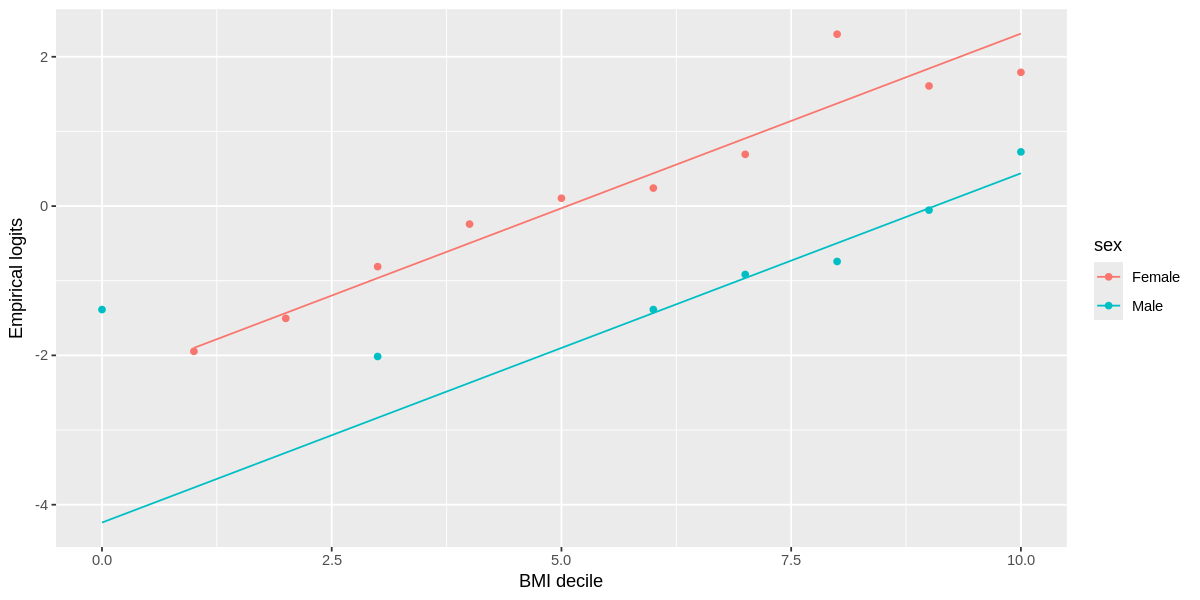

In [19]:
ggplot(data = empirical.logits.sex %>% filter(p > 0 & p < 1)) +
  geom_point(aes(x = bmidecile, y = logit.p,col=sex)) +
      geom_line(aes(x = bmidecile, y = fitted.values,col=sex)) +
    xlab('BMI decile') + ylab('Empirical logits')

* Provide a visual interpretation of $\hat\beta_0$.
  * **The intercept of the red line: fitted logit(p) in BMI decile = 0.**
* Provide a visual interpretation of $\hat\beta_1$.
  * **The slope of both lines.**
* Provide a visual interpretation of $\hat\beta_2$.
  * **The gap between the lines (negative becasue males are beelow females).**

In [20]:
exp(coef(bmi.sex.nointeraction))

(Intercept)   bmidecile     sexMale 
 0.09369965  1.59655907  0.15391160

In [21]:
exp(confint(bmi.sex.nointeraction))

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),0.04745060,0.1763842
bmidecile,1.44859711,1.7747971
sexMale,0.09093211,0.2524824


* Interpret $\exp(\hat\beta_0)$.
  - **The odds of female in the 0 BMI decile trying to lose weight are 0.09.**
* Interpret $\exp(\hat\beta_1)$, and fully summarize what this model tells us about the relationship between $Y$ and BMI, conditioned on sex.
  - **The odds of trying to lose weight are 1.6 times higher for each 1-deciles increase in BMI, COMPARING PEOPLE ON THE SAME SEX. Statistically significant relationship (p-value for this coefficient is < 0.0001, 95% CI for the odds ratio: 1.4, 1.8 does not overlap 1).**
* Interpret $\exp(\hat\beta_2)$, and fully summarize what this model tells us about the relationship between $Y$ and sex, conditioned on BMI.
  - **The odds of trying to lose weight among males are 15% as heigh as the odds for females, COMPARING PEOPLE IN THE SAME BMI DECILE. This is a statistically significant relationship (p-value < 0.0001, 95% CI: 0.09, 0.25 lines entily below 1).**

## Model fitting: interaction

Our exploratory analysis did not suggest much evidence of interaction between BMI and sex, but we can fit an interaction model anyways to see if it results in any improvement in fit.  Specifically, we will fit the model:

$$logit(p) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1\cdot X_2$$

 Conceptually, this model *allows for* the possibility that:

1. The weight loss desire/BMI relationship differs by sex;
2.  The weight loss desire/sex relationship may be wider or narrower depending on that teen's BMI.



Fitting the model:


In [22]:
bmi.sex.interaction <- glm(lose.wt.01~bmidecile * sex, data = yrbss, family=binomial)
summary(bmi.sex.interaction)


Call:
glm(formula = lose.wt.01 ~ bmidecile * sex, family = binomial, 
    data = yrbss)

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -2.21376    0.40098  -5.521 3.37e-08 ***
bmidecile          0.44053    0.06504   6.774 1.26e-11 ***
sexMale           -2.37660    0.81963  -2.900  0.00374 ** 
bmidecile:sexMale  0.07079    0.10767   0.657  0.51088    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 611.93  on 444  degrees of freedom
Residual deviance: 460.77  on 441  degrees of freedom
AIC: 468.77

Number of Fisher Scoring iterations: 5


Adding the fitted values to the empirical logit data frame, and plotting:

In [23]:
empirical.logits.sex$fitted.values.interaction <- predict(bmi.sex.interaction, newdata = empirical.logits.sex)

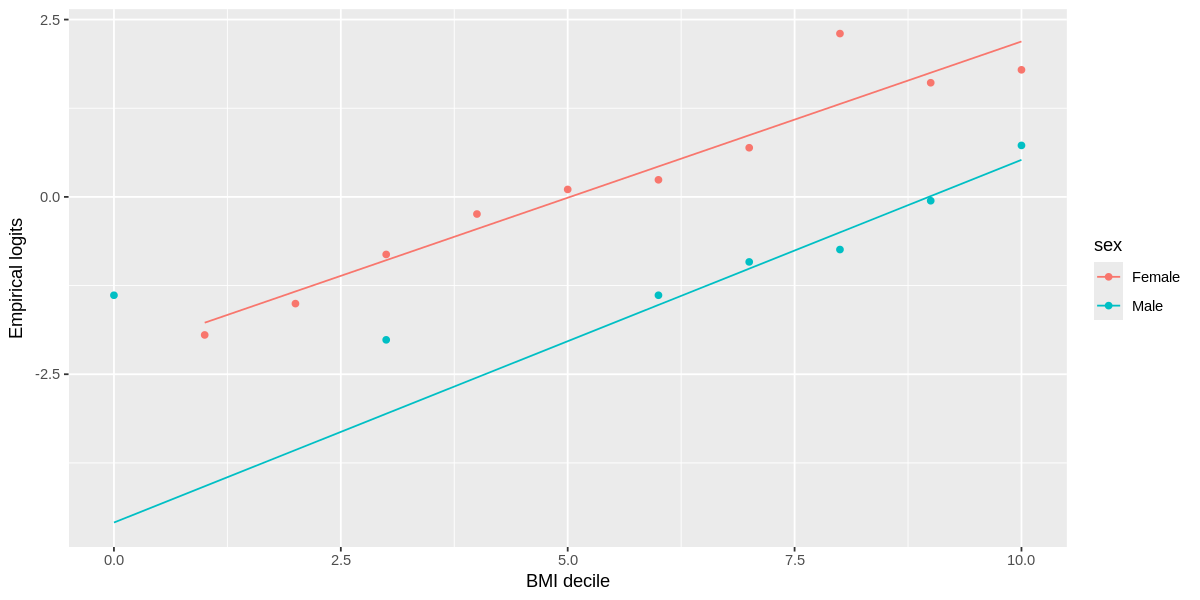

In [24]:
ggplot(data = empirical.logits.sex %>% filter(p > 0 & p < 1)) +
  geom_point(aes(x = bmidecile, y = logit.p,col=sex)) +
      geom_line(aes(x = bmidecile, y = fitted.values.interaction,col=sex)) +
    xlab('BMI decile') + ylab('Empirical logits')

* Find the equation of the fitted red line for females: $\widehat{logit}(p_i|female) = $
* Find the equation of the fitted blue line for males: $\widehat{logit}(p_i|male) = $

* Provide a visual interpretation of $\hat\beta_0$.
* Provide a visual interpretation of $\hat\beta_1$.
* Provide a visual interpretation of $\hat\beta_2$.
* Provide a visual interpretation of $\hat\beta_3$.
* Is there evidence that the *strength* of the relationship of $logit(p)$ with BMI differs by sex?  Explain.

## Testing nested models

While we can simply look at testing whether $\beta_3= 0$ to determine evidence for interaction, we can also use the drop-in-deviance, i.e. likelihood ratio test because we have nested models.  Specifically:



$$\mbox{No interaction model: }logit(p) = \beta_0 + \beta_1 X_1 + \beta_2 X_2$$
$$\mbox{Interaction model: }logit(p) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1\cdot X_2$$

Let's find the residual deviances:

In [25]:
deviance(bmi.sex.nointeraction)

[1] 461.212

In [26]:
deviance(bmi.sex.interaction)

[1] 460.7725

The residual deviance of the interaction model is very slightly smaller than the no interaction model, but not by much.  (Recall the deviance is the GLM analogue of sum-of-squared residuals: smaller ⟹ better fit.)

Finding the difference:


In [27]:
deviance(bmi.sex.nointeraction)-deviance(bmi.sex.interaction)

[1] 0.4395467

* Verify that the difference in deviances is just twice the difference in the log-likelihoods.  Use the `logLik()` function to find the maximized log-likelihood of each model.


Determining whether this drop in deviances is *significant*:

In [29]:
anova(bmi.sex.nointeraction, bmi.sex.interaction, test = 'Chisq')

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,442,461.2120,NA,NA,NA
2,441,460.7725,1,0.4395467,0.5073413


* What does this output suggest about whether there is a significant interaction between BMI and sex?

## AIC and BIC

We can also compare the AICs and BICs of the two models.  It comes with the `summary()` output; we can also use the `AIC()` command:

In [30]:
AIC(bmi.sex.nointeraction)

[1] 467.212

In [31]:
AIC(bmi.sex.interaction)

[1] 468.7725

What about BIC?

In [32]:
BIC(bmi.sex.nointeraction)

[1] 479.5062

In [33]:
BIC(bmi.sex.interaction)

[1] 485.1648

* What do these results suggest about which model is preferable?

# Research question 3: is the nonlinear logit for males "real"?

Your turn to model!  Consider the plot below:




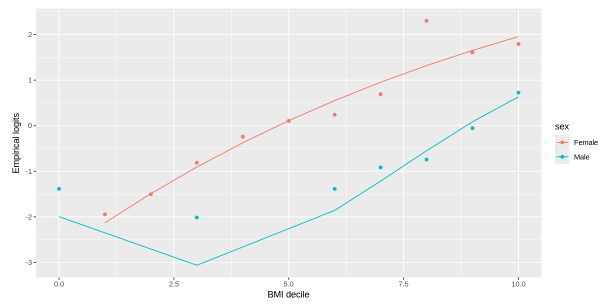

* Given the relationships in this plot, what sorts of terms do we have on BMI decile?
* Does this model reflect that an interaction has been fit?
* See if you can reproduce the model that produced this plot, and the plot itself.  Then determine if this model represents a significant improvement upon the linear, no-interaction model.  What do your results indicate about whether the nonlinear trend for males is 'real' or not?

# Research question 4: Does adding participation in sports and/or media consumption improve the fit?

## Exploratory analysis

Before proceeding with model fitting, let's visually explore if the binary sports participation variable or media consumption appear associated with desire to lose weight, separately for males and females:

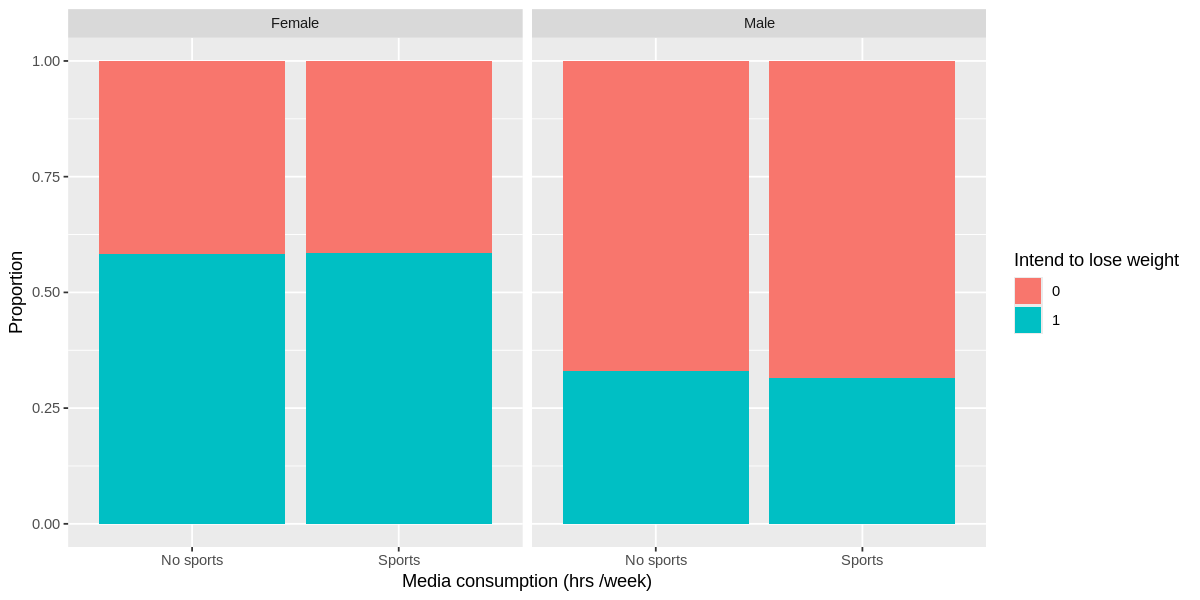

In [34]:
ggplot(data = yrbss) +
  geom_bar(aes(x = sport, fill = factor(lose.wt.01)), position='fill') +
    facet_wrap(~sex) +
      xlab('Media consumption (hrs /week)') + ylab('Proportion') +
        scale_fill_discrete(name = 'Intend to lose weight')

There appears to be virtually no difference between sports participants and non-participants in intent to lose weight, for both males and females.

What about media consumption?

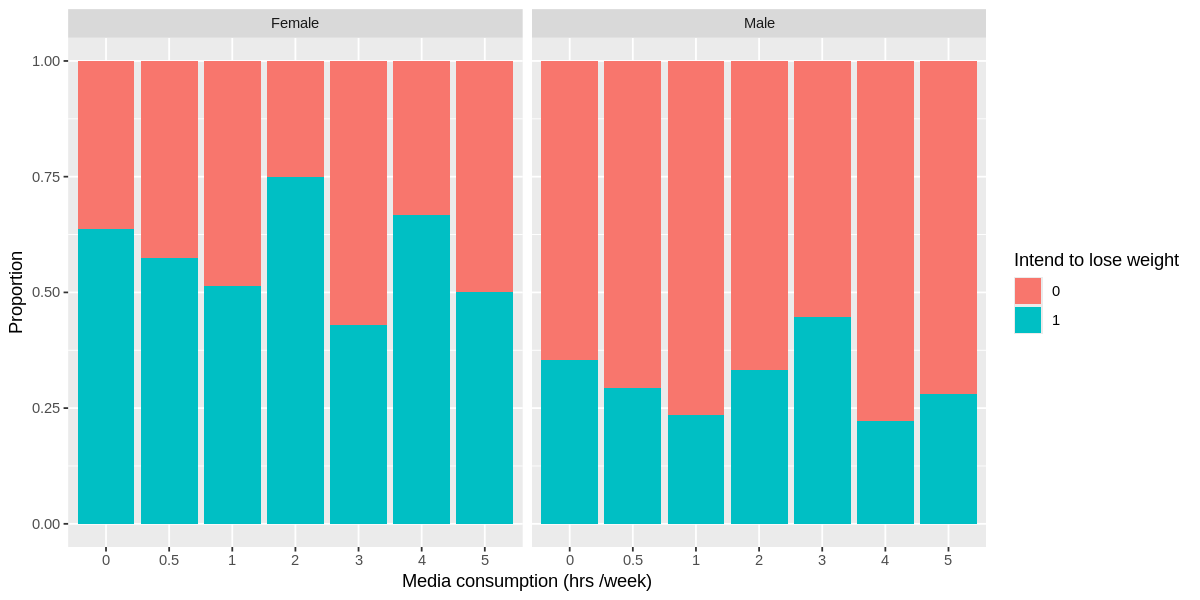

In [35]:
ggplot(data = yrbss) +
  geom_bar(aes(x = factor(media), fill = factor(lose.wt.01)), position='fill') +
    facet_wrap(~sex) +
      xlab('Media consumption (hrs /week)') + ylab('Proportion') +
        scale_fill_discrete(name = 'Intend to lose weight')

While the proportion of teens intending to lose weight is not constant across the media consumption levels, there is no obvious relationship between media consumption and desire to lose weight, for either males or females.

## Model fitting

Since we had very little evidence of interaction between BMI and sex, we will fit the no-interaction BMI and sex model and add in terms for sports participation and media consumption:


$$logit(p) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4$$

where:


$$X_3 = \begin{cases} 1 & \mbox{involved in sports}\\
0 & otherwise\\
\end{cases}$$

$$X_4 = \mbox{media consumption, hrs/week}$$


In [36]:
media.sport.fit <- glm(lose.wt.01~bmidecile + sex + sport + media, data = yrbss, family=binomial)
summary(media.sport.fit)


Call:
glm(formula = lose.wt.01 ~ bmidecile + sex + sport + media, family = binomial, 
    data = yrbss)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.12847    0.37269  -5.711 1.12e-08 ***
bmidecile    0.47593    0.05226   9.107  < 2e-16 ***
sexMale     -1.84689    0.26102  -7.076 1.49e-12 ***
sportSports -0.14315    0.23646  -0.605    0.545    
media       -0.10332    0.07277  -1.420    0.156    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 611.93  on 444  degrees of freedom
Residual deviance: 458.87  on 440  degrees of freedom
AIC: 468.87

Number of Fisher Scoring iterations: 5


## Determining whether adding sports & media is helpful

While it does not appear that any of the *individual* coefficients for `sport` or `media` are significant, we need the drop-in-deviance/likelihood ratio test to test whether *all the terms are simultaneously 0*, i.e. to test:

$$H_0: \mbox{BMI and sex sufficient}; \beta_3=\beta_4  = 0$$
$$H_0: \mbox{sports and/or media add something to the model; at least one of } \beta_3,\beta_4 \ne 0$$

In [37]:
anova(bmi.sex.nointeraction, media.sport.fit, test = 'Chisq')

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,442,461.2120,NA,NA,NA
2,440,458.8681,2,2.343902,0.3097621


Finding the AICs:

In [38]:
AIC(bmi.sex.nointeraction)

[1] 467.212

In [39]:
AIC(media.sport.fit)

[1] 468.8681

BICs:

In [40]:
BIC(bmi.sex.nointeraction)

[1] 479.5062

In [41]:
BIC(media.sport.fit)

[1] 489.3585

The p-value from the likelihood ratio test being > 0.05, and the AIC/BIC from the media + sport fit being larger than the corresponding metrics from the model with just BMI and sex, there appears to be little-to-no evidence of a meaningful relationship between intending to lose weight, participation in sports, and media consumption after controlling for BMI and sex.